# Current-based LIF network

Non-plastic spiking network with current-based synapses and balanced state demo (in asynchronous irregular regime).

In [1]:
%reset -f
%matplotlib inline
from copy import deepcopy as copy
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter1d as smooth
from scipy.ndimage import uniform_filter1d as mv_avg
from scipy import stats

from aux import Generic
from disp import set_font_size, set_color
from ntwk import LIFNtwkI, join_w

cc = np.concatenate

## Random balanced network

Equal numbers of E & I neurons.

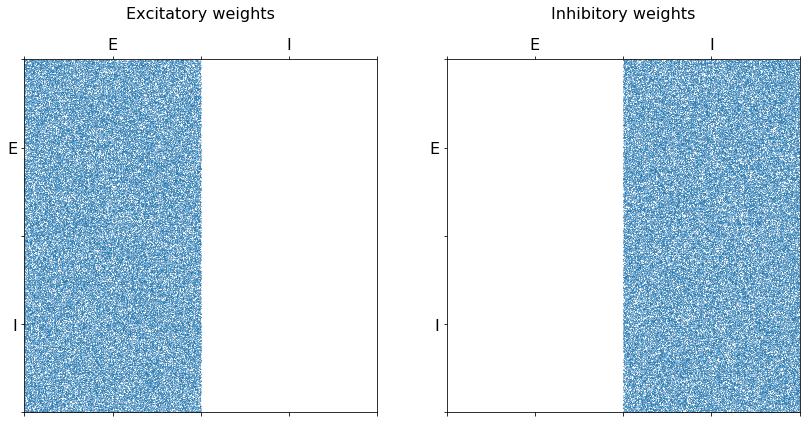

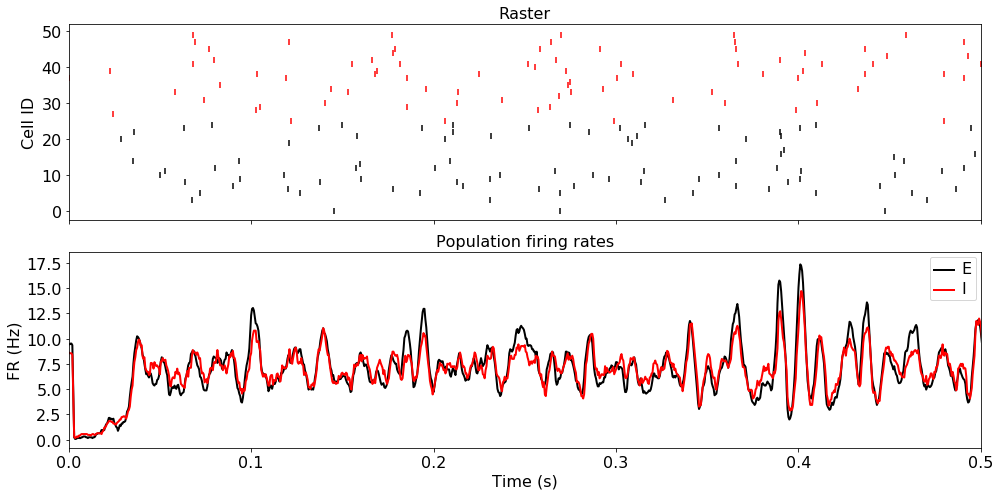

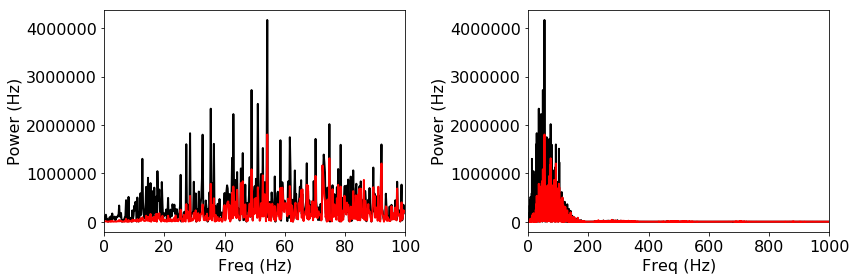

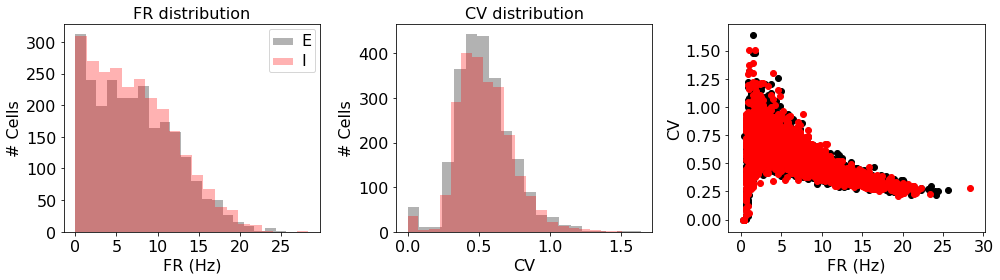

In [2]:
np.random.seed(0)

# set up weight matrix
n_e = 2500
n_i = 2500
n = n_e + n_i

q = 0.01  # cxn prob
w_ee = .2e-9  # E->E cxn weight
w_ie = w_ee  # E->I cxn weight
g = 3  # scale factor for I weights (w_ei = g*w_ee, w_ii = g*w_ie)
w_ei = -g*w_ee  # I->E cxn weight
w_ii = -g*w_ie  # I->I cxn weight

## make dict of indiv weight matrices for all cxn types
w_r_indiv = {
    'W': {
        ('E', 'E'): w_ee*(np.random.rand(n_e, n_e) < q),
        ('I', 'E'): w_ie*(np.random.rand(n_i, n_e) < q),
        ('E', 'I'): w_ei*(np.random.rand(n_e, n_i) < q),
        ('I', 'I'): w_ii*(np.random.rand(n_i, n_i) < q),
    },
}

## cell types vector
ct = cc([np.repeat('E', n_e), np.repeat('I', n_i)])

w_r = join_w(ct, ct, w_r_indiv)['W']

if True:  ## plot sparsity structure
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), tight_layout=True)
    w_r_e = copy(w_r)
    w_r_e[w_r < 0] = 0
    axs[0].spy(w_r_e, markersize=.1)
    axs[0].set_title('Excitatory weights\n')
    
    w_r_i = copy(w_r)
    w_r_i[w_r > 0] = 0
    axs[1].spy(w_r_i, markersize=.1)
    axs[1].set_title('Inhibitory weights\n')

    for ax in axs:
        ax.set_xticks([-.5, 1249.5, 2499.5, 3749.5, 4999.5])
        ax.set_xticklabels(['', 'E', '', 'I', ''])
        ax.set_yticks([-.5, 1249.5, 2499.5, 3749.5, 4999.5])
        ax.set_yticklabels(['', 'E', '', 'I', ''])

        set_font_size(ax, 16)

# make ntwk
ntwk = LIFNtwkI(
    c_m=.2e-9,  # F
    g_l=10e-9,  # S
    e_l=-0.05,  # V
    v_th=-0.04,  # V
    v_r=-0.05,
    t_r=0.002,  # s
    w_r=w_r,
    w_u=None,
    sparse=True)

# run smln
dt = 0.0005
n_t = int(5/dt)
t = dt * np.arange(n_t, dtype=float)
clamp = Generic(v={0: np.random.normal(-0.06, .01, n)}, spk={})
i_ext = .11e-9 * np.ones((n_t))

rslt = ntwk.run(dt=dt, clamp=clamp, i_ext=i_ext)
spks_t = rslt.spks_t
spks_c = rslt.spks_c

# plot smln results
fig, axs = plt.subplots(2, 1, figsize=(14, 7), sharex=True, tight_layout=True)

## raster
mask_e = spks_c < 25  # first 25 E cells
axs[0].scatter(spks_t[mask_e], spks_c[mask_e], c='k', marker='|')
mask_i = (n_e <= spks_c) & (spks_c < n_e + 25)  # first 25 I cells
axs[0].scatter(spks_t[mask_i], spks_c[mask_i] - n_e + 25, c='r', marker='|')  # I

axs[0].set_title('Raster')
axs[0].set_ylabel('Cell ID')

## ppln firing rates
wdw_fr_int = int(round(.005/dt))  # smoothing window
fr_e = mv_avg(rslt.spks[:, :n_e].mean(axis=1)/dt, wdw_fr_int)
fr_i = mv_avg(rslt.spks[:, n_e:].mean(axis=1)/dt, wdw_fr_int)
axs[1].plot(t, fr_e, c='k', lw=2)
axs[1].plot(t, fr_i, c='r', lw=2)

axs[1].set_title('Population firing rates')
axs[1].set_ylabel('FR (Hz)')
axs[1].set_xlabel('Time (s)')
axs[1].legend(['E', 'I'])

for ax in axs:
    ax.set_xlim(0, .5)
    set_font_size(ax, 16)
    
# analyze results
## power spectrum
fs = 1/dt
n_fft = len(t[t > 0.2])
fr_e_fft = np.fft.fft(fr_e[t > 0.2] - np.mean(fr_e[t > 0.2]), n_fft)
fr_i_fft = np.fft.fft(fr_i[t > 0.2] - np.mean(fr_i[t > 0.2]), n_fft)
fr_e_psd = np.abs(fr_e_fft)**2
fr_i_psd = np.abs(fr_i_fft)**2
frq = np.fft.fftfreq(n_fft, dt)

fig, axs = plt.subplots(1, 2, figsize=(12, 4), tight_layout=True)
for ax in axs:
    ax.plot(frq[:int(len(frq)/2)], fr_e_psd[:int(len(frq)/2)], c='k', lw=2)
    ax.plot(frq[:int(len(frq)/2)], fr_i_psd[:int(len(frq)/2)], c='r', lw=2)
    ax.set_xlabel('Freq (Hz)')
    ax.set_ylabel('Power (Hz)')
    
axs[0].set_xlim(0, 100)
axs[1].set_xlim(0, fs/2)

for ax in axs:
    set_font_size(ax, 16)

## calc ISI distributions
isis_e = [dt*np.diff(spk.nonzero()[0]) for spk in rslt.spks[t >= .15, :n_e].T]
isis_i = [dt*np.diff(spk.nonzero()[0]) for spk in rslt.spks[t >= .15, n_e:].T]

## calc FR distributions
fr_e = rslt.spks[t >= .2, :n_e].sum(0) / (t[-1] - .2)  # E
fr_i = rslt.spks[t >= .2, n_e:].sum(0) / (t[-1] - .2)  # I

## calc ISI coef of variation
cv_e = np.array([stats.variation(isi) for isi in isis_e])
cv_i = np.array([stats.variation(isi) for isi in isis_i])

## plot FR and ISI-CV distributions
fig, axs = plt.subplots(1, 3, figsize=(14, 4), tight_layout=True)

axs[0].hist(fr_e, bins=20, color='k', alpha=.3)
axs[0].hist(fr_i, bins=20, color='r', alpha=.3)

axs[0].set_title('FR distribution')
axs[0].set_xlabel('FR (Hz)')
axs[0].set_ylabel('# Cells')
axs[0].legend(['E', 'I'])

axs[1].hist(cv_e[~np.isnan(cv_e)], bins=20, color='k', alpha=.3)
axs[1].hist(cv_i[~np.isnan(cv_i)], bins=20, color='r', alpha=.3)

axs[1].set_xticks([0, .5, 1, 1.5])

axs[1].set_title('CV distribution')
axs[1].set_xlabel('CV')
axs[1].set_ylabel('# Cells')

axs[2].scatter(fr_e, cv_e, color='k')
axs[2].scatter(fr_i, cv_i, color='r')

axs[2].set_xlabel('FR (Hz)')
axs[2].set_ylabel('CV')

for ax in axs:
    set_font_size(ax, 16)

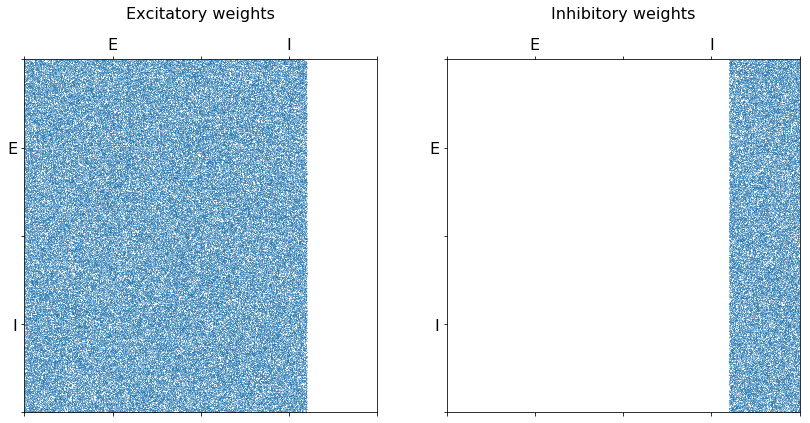

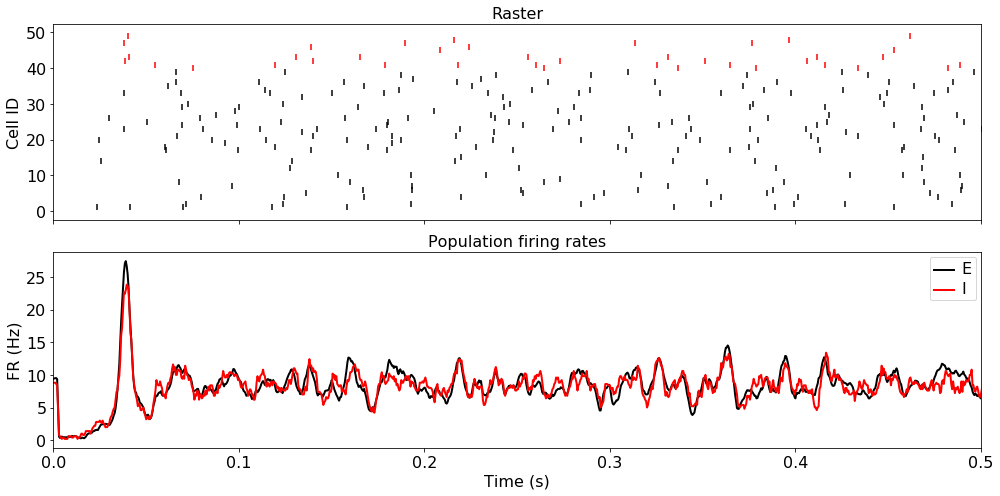

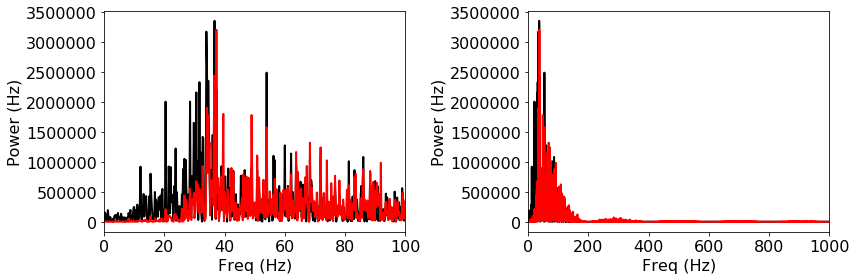

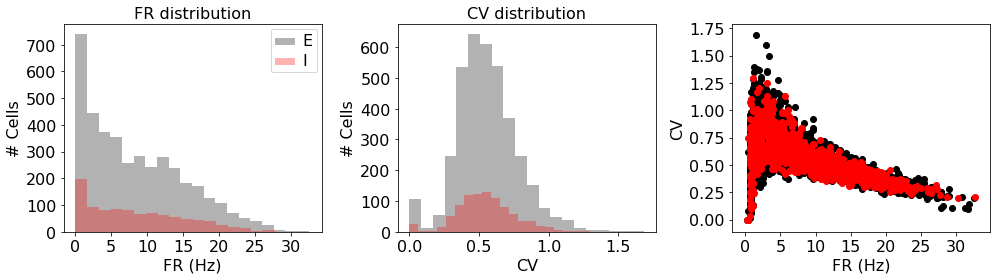

In [3]:
np.random.seed(0)

# set up weight matrix
n_e = 4000
n_i = 1000
n = n_e + n_i

q = 0.01  # cxn prob
w_ee = .12e-9  # E->E cxn weight
w_ie = w_ee  # E->I cxn weight
g = 15  # scale factor for I weights (w_ei = g*w_ee, w_ii = g*w_ie)
w_ei = -g*w_ee  # I->E cxn weight
w_ii = -g*w_ie  # I->I cxn weight

## make dict of indiv weight matrices for all cxn types
w_r_indiv = {
    'W': {
        ('E', 'E'): w_ee*(np.random.rand(n_e, n_e) < q),
        ('I', 'E'): w_ie*(np.random.rand(n_i, n_e) < q),
        ('E', 'I'): w_ei*(np.random.rand(n_e, n_i) < q),
        ('I', 'I'): w_ii*(np.random.rand(n_i, n_i) < q),
    },
}

## cell types vector
ct = cc([np.repeat('E', n_e), np.repeat('I', n_i)])

w_r = join_w(ct, ct, w_r_indiv)['W']

if True:  ## plot sparsity structure
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), tight_layout=True)
    w_r_e = copy(w_r)
    w_r_e[w_r < 0] = 0
    axs[0].spy(w_r_e, markersize=.1)
    axs[0].set_title('Excitatory weights\n')
    
    w_r_i = copy(w_r)
    w_r_i[w_r > 0] = 0
    axs[1].spy(w_r_i, markersize=.1)
    axs[1].set_title('Inhibitory weights\n')

    for ax in axs:
        ax.set_xticks([-.5, 1249.5, 2499.5, 3749.5, 4999.5])
        ax.set_xticklabels(['', 'E', '', 'I', ''])
        ax.set_yticks([-.5, 1249.5, 2499.5, 3749.5, 4999.5])
        ax.set_yticklabels(['', 'E', '', 'I', ''])

        set_font_size(ax, 16)

# make ntwk
ntwk = LIFNtwkI(
    c_m=.2e-9,  # F
    g_l=10e-9,  # S
    e_l=-0.05,  # V
    v_th=-0.04,  # V
    v_r=-0.05,
    t_r=0.002,  # s
    w_r=w_r,
    w_u=None,
    sparse=True)

# run smln
dt = 0.0005
n_t = int(5/dt)
t = dt * np.arange(n_t, dtype=float)
clamp = Generic(v={0: np.random.normal(-0.06, .01, n)}, spk={})
i_ext = .11e-9 * np.ones((n_t))

rslt = ntwk.run(dt=dt, clamp=clamp, i_ext=i_ext)
spks_t = rslt.spks_t
spks_c = rslt.spks_c

# plot smln results
fig, axs = plt.subplots(2, 1, figsize=(14, 7), sharex=True, tight_layout=True)

## raster
mask_e = spks_c < 40  # first 40 E cells
axs[0].scatter(spks_t[mask_e], spks_c[mask_e], c='k', marker='|')
mask_i = (n_e <= spks_c) & (spks_c < n_e + 10)  # first 10 I cells
axs[0].scatter(spks_t[mask_i], spks_c[mask_i] - n_e + 40, c='r', marker='|')  # I

axs[0].set_title('Raster')
axs[0].set_ylabel('Cell ID')

## ppln firing rates
wdw_fr_int = int(round(.005/dt))  # smoothing window
fr_e = mv_avg(rslt.spks[:, :n_e].mean(axis=1)/dt, wdw_fr_int)
fr_i = mv_avg(rslt.spks[:, n_e:].mean(axis=1)/dt, wdw_fr_int)
axs[1].plot(t, fr_e, c='k', lw=2)
axs[1].plot(t, fr_i, c='r', lw=2)

axs[1].set_title('Population firing rates')
axs[1].set_ylabel('FR (Hz)')
axs[1].set_xlabel('Time (s)')
axs[1].legend(['E', 'I'])

for ax in axs:
    ax.set_xlim(0, .5)
    set_font_size(ax, 16)
    
# analyze results
## power spectrum
fs = 1/dt
n_fft = len(t[t > 0.2])
fr_e_fft = np.fft.fft(fr_e[t > 0.2] - np.mean(fr_e[t > 0.2]), n_fft)
fr_i_fft = np.fft.fft(fr_i[t > 0.2] - np.mean(fr_i[t > 0.2]), n_fft)
fr_e_psd = np.abs(fr_e_fft)**2
fr_i_psd = np.abs(fr_i_fft)**2
frq = np.fft.fftfreq(n_fft, dt)

fig, axs = plt.subplots(1, 2, figsize=(12, 4), tight_layout=True)
for ax in axs:
    ax.plot(frq[:int(len(frq)/2)], fr_e_psd[:int(len(frq)/2)], c='k', lw=2)
    ax.plot(frq[:int(len(frq)/2)], fr_i_psd[:int(len(frq)/2)], c='r', lw=2)
    ax.set_xlabel('Freq (Hz)')
    ax.set_ylabel('Power (Hz)')
    
axs[0].set_xlim(0, 100)
axs[1].set_xlim(0, fs/2)

for ax in axs:
    set_font_size(ax, 16)

## calc ISI distributions
isis_e = [dt*np.diff(spk.nonzero()[0]) for spk in rslt.spks[t >= .15, :n_e].T]
isis_i = [dt*np.diff(spk.nonzero()[0]) for spk in rslt.spks[t >= .15, n_e:].T]

## calc FR distributions
fr_e = rslt.spks[t >= .2, :n_e].sum(0) / (t[-1] - .2)  # E
fr_i = rslt.spks[t >= .2, n_e:].sum(0) / (t[-1] - .2)  # I

## calc ISI coef of variation
cv_e = np.array([stats.variation(isi) for isi in isis_e])
cv_i = np.array([stats.variation(isi) for isi in isis_i])

## plot FR and ISI-CV distributions
fig, axs = plt.subplots(1, 3, figsize=(14, 4), tight_layout=True)

axs[0].hist(fr_e, bins=20, color='k', alpha=.3)
axs[0].hist(fr_i, bins=20, color='r', alpha=.3)

axs[0].set_title('FR distribution')
axs[0].set_xlabel('FR (Hz)')
axs[0].set_ylabel('# Cells')
axs[0].legend(['E', 'I'])

axs[1].hist(cv_e[~np.isnan(cv_e)], bins=20, color='k', alpha=.3)
axs[1].hist(cv_i[~np.isnan(cv_i)], bins=20, color='r', alpha=.3)

axs[1].set_xticks([0, .5, 1, 1.5])

axs[1].set_title('CV distribution')
axs[1].set_xlabel('CV')
axs[1].set_ylabel('# Cells')

axs[2].scatter(fr_e, cv_e, color='k')
axs[2].scatter(fr_i, cv_i, color='r')

axs[2].set_xlabel('FR (Hz)')
axs[2].set_ylabel('CV')

for ax in axs:
    set_font_size(ax, 16)